# Circus Oz: Preliminary Analysis

In [113]:
# for data mgmt
import pandas as pd
import numpy as np
from collections import Counter

# for plotting
import matplotlib.pyplot as plt

# for network graphs
import networkx as nx
from pyvis import network as net
from IPython.display import IFrame

# for statistical processes
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import pareto

import warnings
warnings.filterwarnings("ignore")

In [114]:
df = pd.read_excel('data/23 Nov_Circus Oz_MasterList-RoleCategories_1978-2009_Clean.xlsx')
df.head()

,EVENT.NUMBER,TYPE,TITLE,UMBRELLA.EVENT,UMBRELLA.EVENT.2,DATE.FROM.(General),DATE.TO.(General),(TBC)_VENUE.NAME_(TBC),(TBC)_VENUE.LOCATION,(TBC)_VENUE.TYPE,PERSON.NUMBER,FIRST.NAME,SECOND.NAME,COMBINED.NAME,ALTERNATIVE.SPELLING (Discrepancy or inaccuracy),Gender,Role.Category.Concatinate
0,E0001,off season,NaN,NaN,NaN,1977-06-01 00:00:00,1978-01-17 00:00:00,NaN,NaN,NaN,P0704,Tim,Coldwell,Tim Coldwell,NaN,M,Performer
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P0408,Laurel,Frank,Laurel Frank,Frank Laurel,F,KeyCreative
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P0264,Hellen,Sky,Hellen Sky,NaN,F,Performer
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P0082,Bob,Thorneycroft,Bob Thorneycroft,NaN,M,Performer
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P0595,Robin,Laurie,Robin Laurie,Robyn Laurie,F,Performer


In [115]:
# remove redundant rows
df = df[~df['PERSON.NUMBER'].isnull()]

# assign event number to each related person
for idx,row in df.iterrows():
    if pd.isnull(row['EVENT.NUMBER']): 
        for col, val in row_dict.items(): df.at[idx, col] = val
    else: 
        row_dict = row.loc["EVENT.NUMBER":"(TBC)_VENUE.TYPE"].to_dict()
        
# create separate events dataset
events_df = df.loc[:,"EVENT.NUMBER":"(TBC)_VENUE.TYPE"]\
              .drop_duplicates()\
              .reset_index(drop=True)

### Event participation by demi-decade

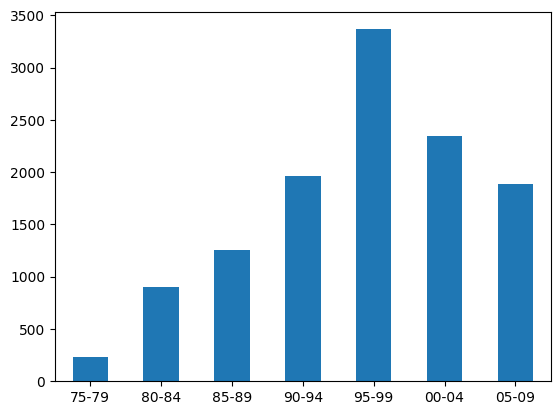

In [116]:
df['Year'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%Y'))
df['Year'] = df['Year'].astype(int)
df['Year_decade'] = [ int(np.floor(int(year)/5) * 5) 
                            for year in np.array(df['Year'])]

ax = df['Year_decade'].value_counts().reset_index().sort_values('index').head(-1)\
.plot(x='index',y='Year_decade', kind='bar', rot=0)

ax.set_xlabel('')
plt.xticks(range(0, 7, 1), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])

# adjust legend
plt.legend().set_visible(False)

### Event participation by year

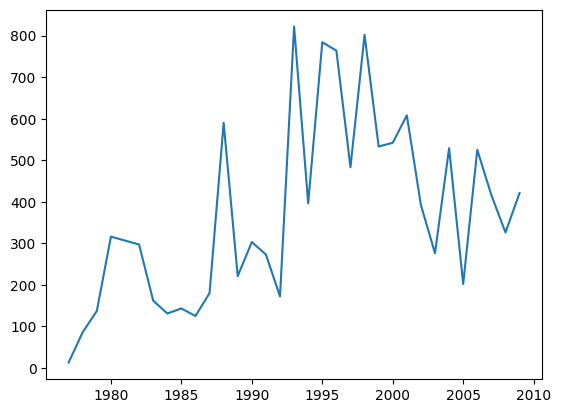

In [117]:
ax = df['Year'].value_counts().reset_index().sort_values('index').head(-1)\
.plot(x='index',y='Year', rot=0)

ax.set_xlabel('')

# adjust legend
plt.legend().set_visible(False)

### Event participation by month

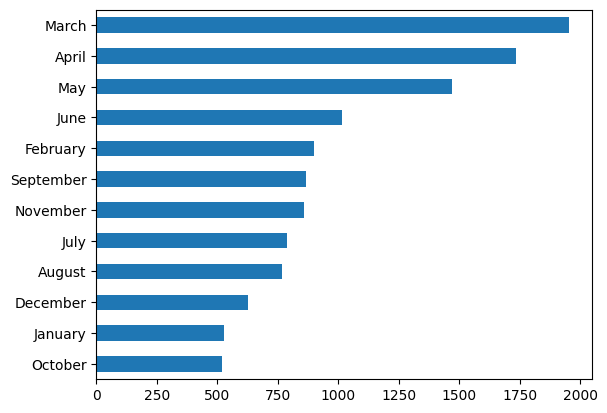

In [118]:
df['Month'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%B'))
df['month_number'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%m'))
ordered_months = df[['Month','month_number']]\
.drop_duplicates()\
.sort_values('month_number')['Month']\
.unique()

df['Month'] = pd.Categorical(df['Month'],categories=ordered_months, ordered=True)

df['Month'].value_counts().sort_values().plot(kind='barh')
plt.show()

### Gender summary

  Gender  Frequency
0      M       4586
1      F       4937
2      U         32
3      0       2443
4    NaN         12


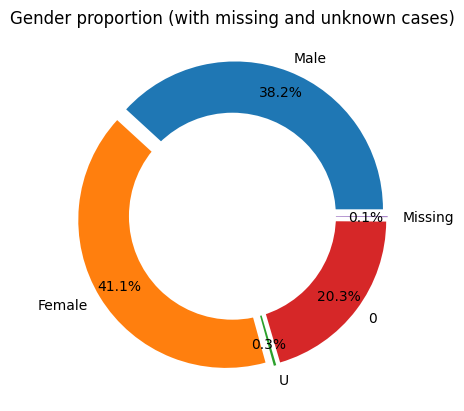

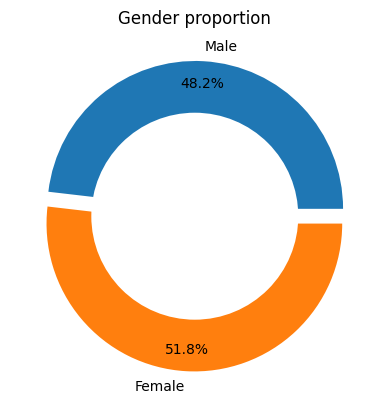

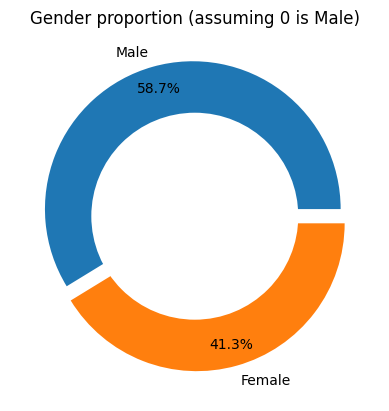

In [119]:
## Gender Proportion
df_gender=pd.DataFrame(dict(Counter(df["Gender"])).items(),
                              columns=["Gender","Frequency"])
print(df_gender)

# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender['Frequency'], labels=['Male','Female','U',0,'Missing'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion (with missing and unknown cases)')
  
# Displaying Chart
plt.show()

# without null
# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender[df_gender['Gender'].isin(['M','F'])]['Frequency'], 
        labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion')
  
# Displaying Chart
plt.show()


# Pie Chart
plt.pie(df_gender[df_gender['Gender'].isin(['M','F',0])]\
        .replace({0: 'M'})\
        .groupby('Gender')\
        .sum()\
        .reset_index()\
        .sort_values('Gender',ascending=False)['Frequency'], 
        labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion (assuming 0 is Male)')
  
# Displaying Chart
plt.show()

### Participation by time


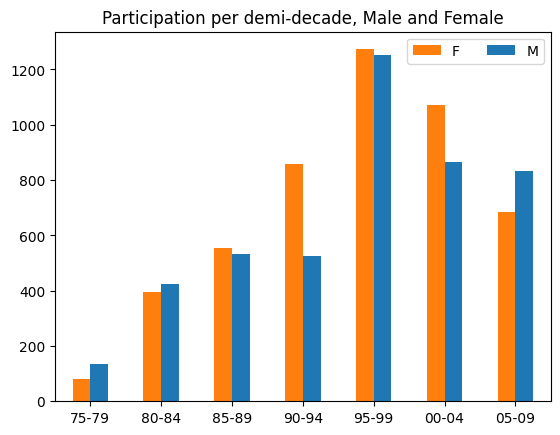

In [120]:
bymf= df[(df['Gender'].isin(['M','F'])) & (df.Year_decade < 2010)]
ax = pd.crosstab(bymf['Year_decade'], 
            bymf['Gender'])\
.plot(kind='bar', rot=0, color=['tab:orange','tab:blue'])
plt.legend(loc="upper right", ncol=2)
plt.title('Participation per demi-decade, Male and Female', )
ax.set_xlabel('')
plt.xticks(range(0, 7, 1), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

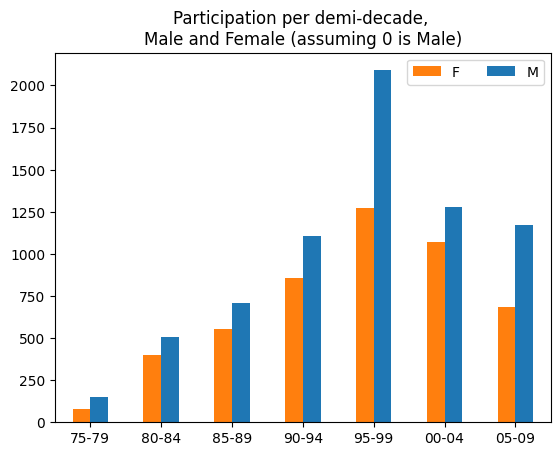

In [121]:
bymf2 = df[(df['Gender'].isin(['M','F',0])) & (df.Year_decade < 2010)]
bymf2['Gender'] = np.where(bymf2['Gender'] == 0, 'M', bymf2['Gender'])

ax = pd.crosstab(bymf2['Year_decade'], 
            bymf2['Gender'])\
.plot(kind='bar', rot=0, color=['tab:orange','tab:blue'])
plt.legend(loc="upper right", ncol=2)
plt.title('Participation per demi-decade, \nMale and Female (assuming 0 is Male)', )
ax.set_xlabel('')
plt.xticks(range(0, 7, 1), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

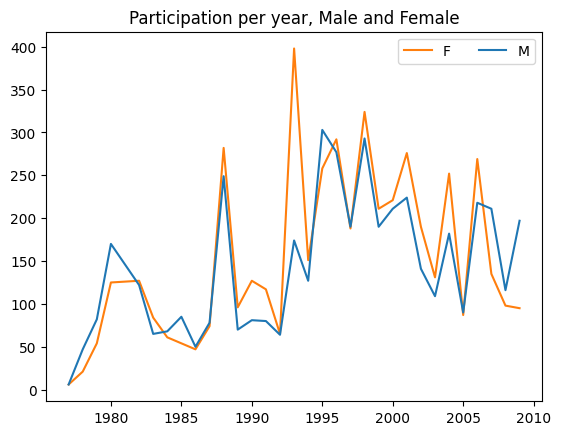

In [122]:
ax = pd.crosstab(bymf['Year'], 
            bymf['Gender'])\
.plot(rot=0, color=['tab:orange','tab:blue'])
plt.legend(loc="upper right", ncol=2)
plt.title('Participation per year, Male and Female', )
ax.set_xlabel('')
plt.show()

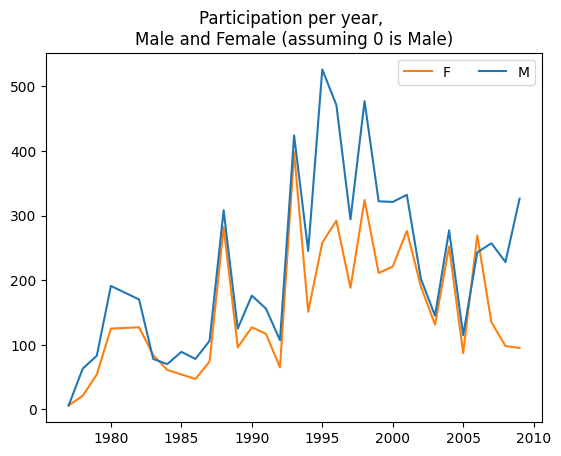

In [123]:
ax = pd.crosstab(bymf2['Year'], 
            bymf2['Gender'])\
.plot(rot=0, color=['tab:orange','tab:blue'])
plt.legend(loc="upper right", ncol=2)
plt.title('Participation per year, \nMale and Female (assuming 0 is Male)', )
ax.set_xlabel('')
plt.show()

### Person summary

- 723 unique persons
- Mean number of events per person = ~17
- However, median (2) is a better measure of centrality as the data is right skewed
- 75% of the data perform in 14 or less events

                count   mean    std   min   25%   50%    75%     max
PERSON.NUMBER 723.000 16.611 36.859 1.000 1.000 2.000 14.000 402.000


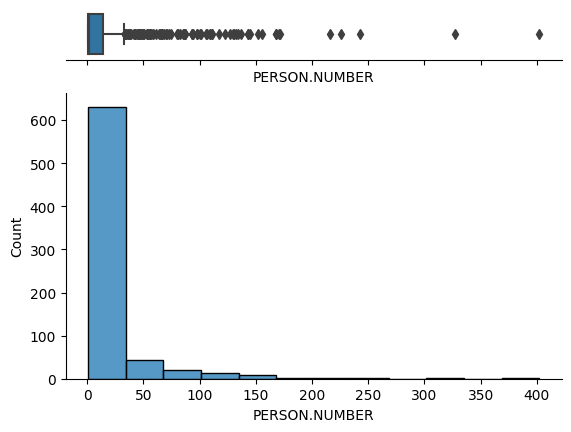

In [124]:
import seaborn as sns

print(pd.DataFrame(df['PERSON.NUMBER'].value_counts().describe()).T)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=df['PERSON.NUMBER'].value_counts(), ax=ax_box)
sns.histplot(x=df['PERSON.NUMBER'].value_counts(), 
             bins=12, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

### Only considering data when gender is filtered by  `male`, `female` and `0`
- Male and Female median is a lot larger when we disregard other values in the Gender column
    - This plays into the idea that people with fewer records have less information about them.
- Compared to male (126) and female (123), 0 occurs far more frequently (407).
- Female median (20) is larger than male (13) and 0 (1).
<br><br>
- 75% of males perform in 38 or less events
- 75% of females perform in 54 or less events
- 75% of 0 perform in 3 or less events

In [125]:
print('\nMale - Participation Summary')
print(pd.DataFrame(df[df['Gender'] == 'M']['PERSON.NUMBER']\
                   .value_counts().describe()).T)

print('\n\nFemale - Participation Summary')
print(pd.DataFrame(df[df['Gender'] == 'F']['PERSON.NUMBER']\
                   .value_counts().describe()).T)

print('\n\n0 - Participation Summary')
print(pd.DataFrame(df[df['Gender'] == 0]['PERSON.NUMBER']\
                   .value_counts().describe()).T)


Male - Participation Summary
                count   mean    std   min   25%    50%    75%     max
PERSON.NUMBER 126.000 36.397 59.659 1.000 4.000 13.000 38.750 402.000


Female - Participation Summary
                count   mean    std   min   25%    50%    75%     max
PERSON.NUMBER 123.000 40.138 47.615 1.000 9.500 20.000 54.500 243.000


0 - Participation Summary
                count  mean    std   min   25%   50%   75%     max
PERSON.NUMBER 470.000 5.198 13.083 1.000 1.000 1.000 3.000 130.000


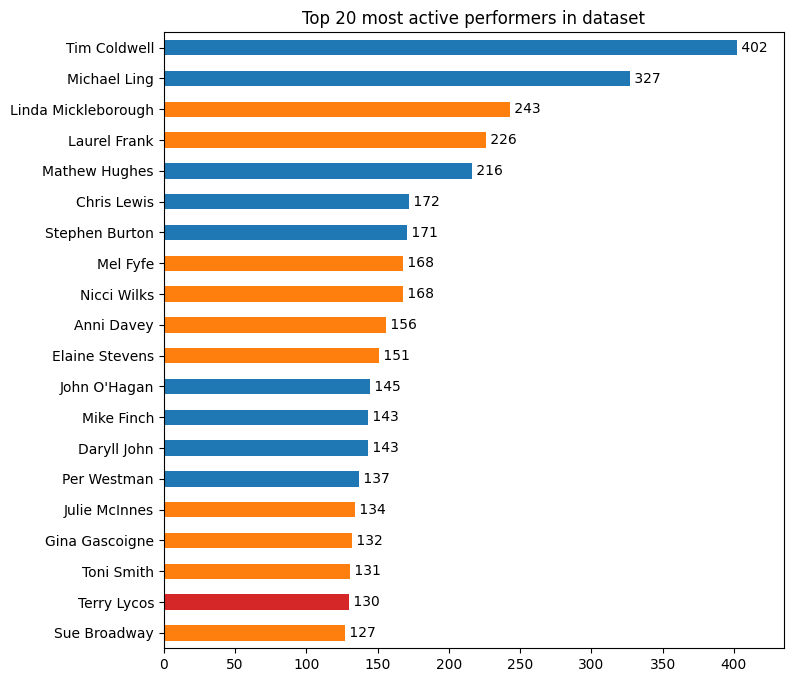

In [126]:
fig, ax = plt.subplots(figsize=(8, 8))

persons_freq = pd.DataFrame(df['COMBINED.NAME'].value_counts())

tab_df = persons_freq\
    .reset_index()\
    .rename({'index':'Person',
             'COMBINED.NAME':'Frequency'}, axis=1)\
    .head(20)\
    .sort_values('Frequency')

# labels = (tab_df['Frequency']/persons_freq.shape[0])\
#         .round(2).astype('str') + '%'

labels = ' ' + tab_df['Frequency'].astype('str')

tab_df.plot.barh(x='Person', y='Frequency',rot=0, ax=ax,
                  color=['tab:orange','tab:red',
                         'tab:orange','tab:orange',
                         'tab:orange','tab:blue',
                         'tab:blue','tab:blue',
                         'tab:blue','tab:orange',
                         'tab:orange','tab:orange',
                         'tab:orange','tab:blue',
                         'tab:blue','tab:blue',
                         'tab:orange','tab:orange',
                         'tab:blue','tab:blue'])

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Top 20 most active performers in dataset')

plt.xlim([0, 435])
plt.show()

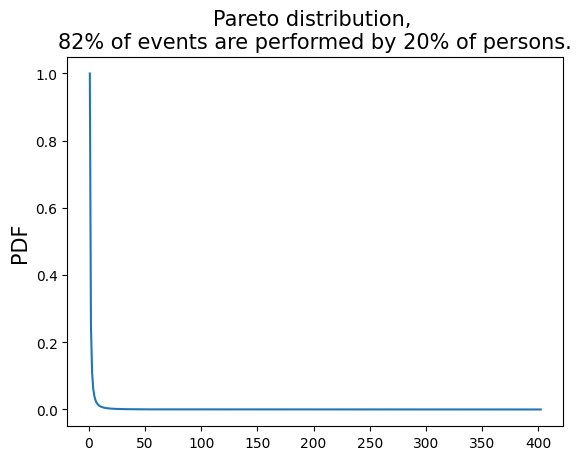

In [47]:
#check for pareto principle
samples = df['PERSON.NUMBER'].value_counts()
output = np.array([pareto.pdf(x=samples, b=1, loc=0, scale=1)])
plt.plot(samples, output.T,label='alpha {0}' .format(1))
    
ax.set_label('samples')
plt.ylabel('PDF', fontsize=15)
plt.title('Pareto distribution, \n82% of events are performed by 20% of persons.', fontsize=15)
plt.show()

### Roles

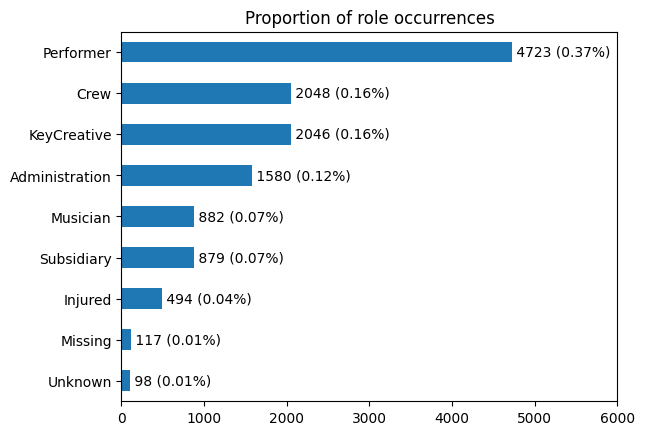

In [48]:
df['Role.Category.Concatinate'] = df['Role.Category.Concatinate'].fillna('Missing')

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in df['Role.Category.Concatinate'].values]
transactions_m = [row.split() for row in 
                  df[df.Gender=='M']['Role.Category.Concatinate'].values]
transactions_f = [row.split() for row in 
                  df[df.Gender=='F']['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles = role_count.sort_values('Count', ascending=True)

labels = ' ' + toproles['Count'].astype('str') + ' (' \
         + (toproles['Count']/toproles['Count'].sum())\
         .round(2).astype('str') + '%)'

ax = toproles.plot.barh(x='Role', y='Count',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Proportion of role occurrences')

plt.xlim([0, 6000])
plt.show()

- 69% of people who are KeyCreatives and Musicians tend to also be Performers
- 41% of people who are Musicians tend to also be Performers
- 26% of people who are KeyCreatives and Performers tend to also be Musicians

In [49]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, 
                             metric="lift", 
                             min_threshold=1)

# rules_ap[rules_ap.lift >= 1].sort_values('confidence', ascending = False).head(10)
rules_ap.sort_values('confidence', ascending = False) #.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(Musician, KeyCreative)",(Performer),0.007,0.393,0.005,0.689,1.752,0.002,1.950
0,(Musician),(Performer),0.073,0.393,0.030,0.415,1.055,0.002,1.037
3,"(Performer, KeyCreative)",(Musician),0.020,0.073,0.005,0.264,3.593,0.004,1.259
1,(Performer),(Musician),0.393,0.073,0.030,0.077,1.055,0.002,1.004
4,(Musician),"(Performer, KeyCreative)",0.073,0.020,0.005,0.070,3.593,0.004,1.055
5,(Performer),"(Musician, KeyCreative)",0.393,0.007,0.005,0.013,1.752,0.002,1.006


- Males who are KeyCreatives tend to also be Performers 6\% more than females
- Females who are Musicians tend to also be Performers 5\% more than males

In [50]:
te = TransactionEncoder()
te_array = te.fit(transactions_m).transform(transactions_m)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_m = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)

te = TransactionEncoder()
te_array = te.fit(transactions_f).transform(transactions_f)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_f = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)


pd.set_option('display.float_format', lambda x: '%.3f' % x)

supports = pd.merge(rules_ap_m, rules_ap_f, on=['antecedents','consequents'])
supports = supports[['antecedents','consequents',
                      'support_x','support_y',
                      'confidence_x','confidence_y']]
supports['diff'] = supports['confidence_x'] - supports['confidence_y']
supports[abs(supports['diff']) > 0.05].sort_values('diff', ascending=False)

,antecedents,consequents,support_x,support_y,confidence_x,confidence_y,diff
3,(KeyCreative),(Performer),0.031,0.019,0.149,0.091,0.057
4,(Musician),(Performer),0.046,0.027,0.445,0.498,-0.053


- On average, people tend to have only one role.

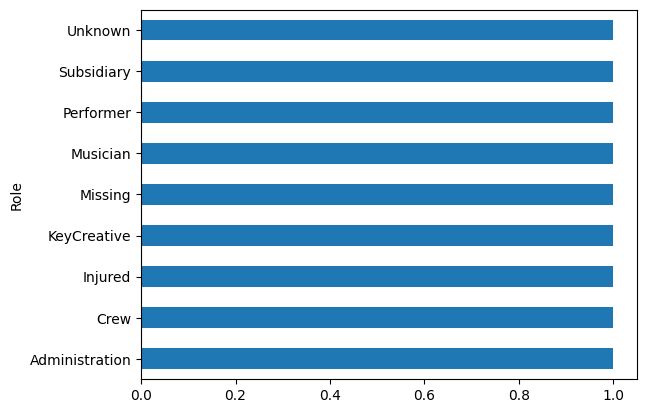

In [51]:
roles_unique = []

for ele in transactions:
    x=np.array(ele)
    roles_unique.extend(x)
    
roles_averages = dict()

for y in list(np.unique(np.array(roles_unique))):
    number_roles = []
    _ = [number_roles.append(len(x)) for x in transactions if y in x]
    roles_averages[y] = pd.DataFrame(number_roles).median().values[0]
    
roles_averages_df = pd.DataFrame(roles_averages.items())
roles_averages_df.columns = ['Role','Avg. no of Roles']
roles_averages_df = roles_averages_df.set_index('Role')
roles_averages_df.sort_values('Avg. no of Roles').plot(kind = 'barh')

# adjust legend
plt.legend().set_visible(False)

plt.show()

- On average, female musicians tend to have one extra role, while majority of male musicians are solely musicians.
- 50% of female musicians are also listed as being a Performer
- 15% of female musicians are also listed as being a KeyCreative

In [52]:
for y in list(np.unique(np.array(roles_unique))):
    number_roles_m = []
    number_roles_f = []
    _ = [number_roles_m.append(len(x)) for x in transactions_m if y in x]
    _ = [number_roles_f.append(len(x)) for x in transactions_f if y in x]
    diff = pd.DataFrame(number_roles_m).median().values[0] - pd.DataFrame(number_roles_f).median().values[0]
    if abs(diff) >= 1: print(y, pd.DataFrame(number_roles_m).median().values[0],
                            pd.DataFrame(number_roles_f).median().values[0])

Musician 1.0 2.0


### Roles (assuming of 0 is Male)

In [53]:
df['Role.Category.Concatinate'] = df['Role.Category.Concatinate'].fillna('Missing')

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in df['Role.Category.Concatinate'].values]
transactions_m = [row.split() for row in 
                  df[(df.Gender=='M') | (df.Gender==0)]['Role.Category.Concatinate'].values]
transactions_f = [row.split() for row in 
                  df[df.Gender=='F']['Role.Category.Concatinate'].values]

- Females who are Muscians tend to also be KeyCreative 6\% more than males
- Females who are Musicians tend to also be Performers 12\% more than males

In [54]:
te = TransactionEncoder()
te_array = te.fit(transactions_m).transform(transactions_m)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_m = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)

te = TransactionEncoder()
te_array = te.fit(transactions_f).transform(transactions_f)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_f = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)


pd.set_option('display.float_format', lambda x: '%.3f' % x)

supports = pd.merge(rules_ap_m, rules_ap_f, on=['antecedents','consequents'])
supports = supports[['antecedents','consequents',
                      'support_x','support_y',
                      'confidence_x','confidence_y']]
supports['diff'] = supports['confidence_x'] - supports['confidence_y']
supports[abs(supports['diff']) > 0.05].sort_values('diff', ascending=False)

,antecedents,consequents,support_x,support_y,confidence_x,confidence_y,diff
0,(Musician),(KeyCreative),0.007,0.008,0.083,0.146,-0.063
4,(Musician),(Performer),0.033,0.027,0.379,0.498,-0.119


- On average, female musicians tend to have one extra role, while majority of male musicians are solely musicians.
- 50% of female musicians are also listed as being a Performer
- 15% of female musicians are also listed as being a KeyCreative

In [55]:
for y in list(np.unique(np.array(roles_unique))):
    number_roles_m = []
    number_roles_f = []
    _ = [number_roles_m.append(len(x)) for x in transactions_m if y in x]
    _ = [number_roles_f.append(len(x)) for x in transactions_f if y in x]
    diff = pd.DataFrame(number_roles_m).median().values[0] - pd.DataFrame(number_roles_f).median().values[0]
    if abs(diff) >= 1: print(y, pd.DataFrame(number_roles_m).median().values[0],
                            pd.DataFrame(number_roles_f).median().values[0])

Musician 1.0 2.0


### Role changes over time

In [56]:
toproles_decade = pd.DataFrame()

### 1975
data_70s = df[df['Year_decade'] == 1975]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1975
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1980
data_70s = df[df['Year_decade'] == 1980]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1980
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()

toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1985
data_70s = df[df['Year_decade'] == 1985]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1985
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1990
data_70s = df[df['Year_decade'] == 1990]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1990
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1995
data_70s = df[df['Year_decade'] == 1995]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1995
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 2000
data_70s = df[df['Year_decade'] == 2000]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2000
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 2005
data_70s = df[df['Year_decade'] == 2005]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2005
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])


### 2010
data_70s = df[df['Year_decade'] == 2010]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2005
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

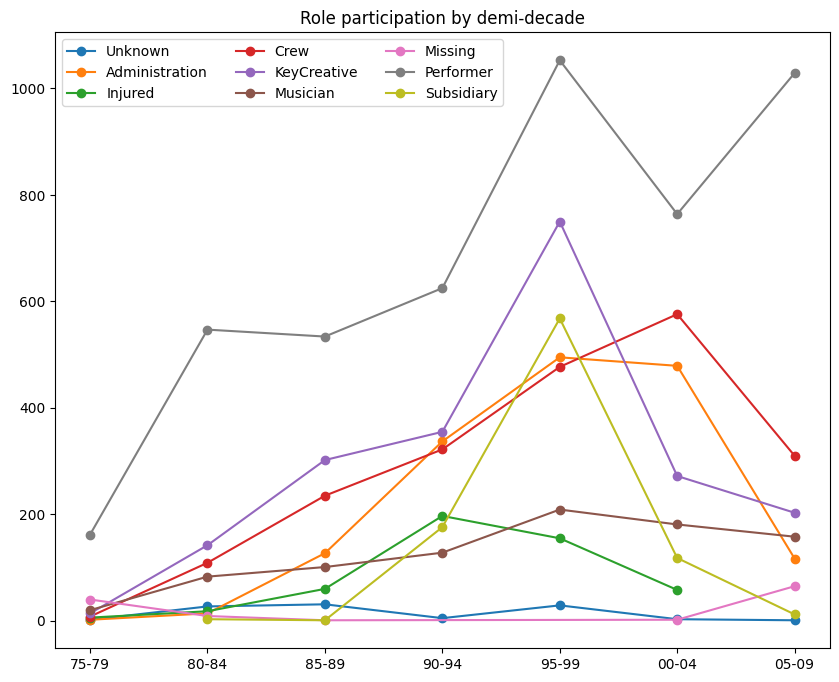

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))

for x in toproles_decade['Role'].unique():
    plt.plot(toproles_decade[toproles_decade['Role']== x]['Decade'],
             toproles_decade[toproles_decade['Role']== x]['Count'], 
             label = x, marker='o')

plt.legend(loc="upper left", ncol=3)
plt.title('Role participation by demi-decade', )
ax.set_xlabel('')

plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

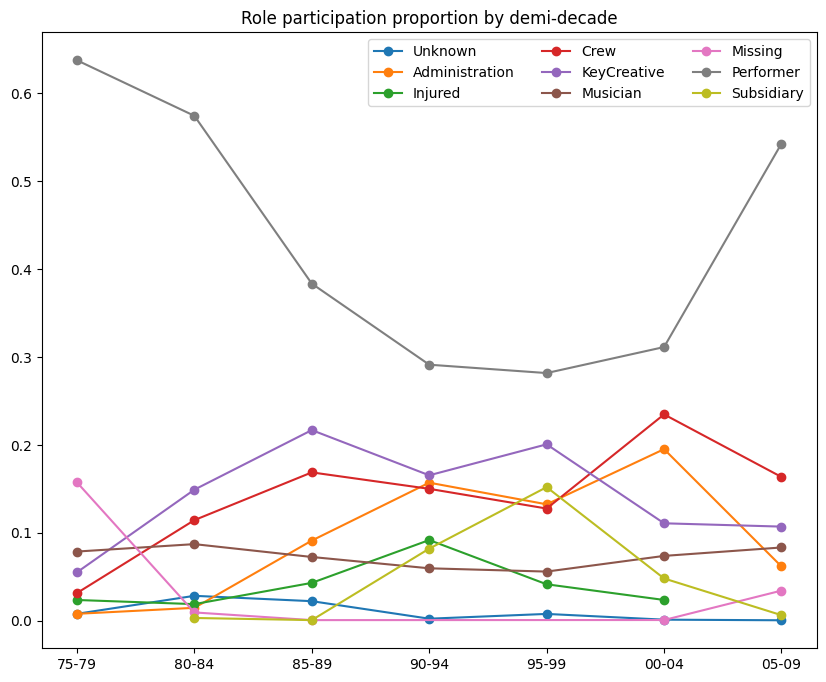

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))

for x in toproles_decade['Role'].unique():
    plt.plot(toproles_decade[toproles_decade['Role']== x]['Decade'],
             toproles_decade[toproles_decade['Role']== x]['Proportion'], 
             label = x, marker='o')

plt.legend(loc="upper right", ncol=3)
plt.title('Role participation proportion by demi-decade', )
ax.set_xlabel('')
plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

### Male and female proportion by role over time

In [59]:
toproles_decade_gender = pd.DataFrame()
supports_decade = pd.DataFrame()

for x in list(df['Year_decade'].unique())[:-1]: 
    ### 1975
    data_70s = df[df['Year_decade'] == x]

    # convert the DataFrame to a list of transactions
    transactions_m = [row.split() for row in 
                      data_70s[(data_70s.Gender=='M') | (df.Gender==0)]['Role.Category.Concatinate'].values]
    transactions_f = [row.split() for row in 
                      data_70s[data_70s.Gender=='F']['Role.Category.Concatinate'].values]
    roles_dict = dict()

    #printing the counts
    for role in transactions_m:
        for r in role:
            if r in roles_dict: roles_dict[r] += 1
            else: roles_dict[r] = 1

    role_count = pd.DataFrame(roles_dict.items(), 
                              columns=['Role', 'Count'])
    toproles_70s_m = role_count.sort_values('Count', ascending=True)
    toproles_70s_m['Decade'] = x
    # toproles_70s_m['Gender'] = 'Male'

    roles_dict = dict()
    
    #printing the counts
    for role in transactions_f:
        for r in role:
            if r in roles_dict: roles_dict[r] += 1
            else: roles_dict[r] = 1

    role_count = pd.DataFrame(roles_dict.items(), 
                              columns=['Role', 'Count'])
    toproles_70s_f = role_count.sort_values('Count', ascending=True)
    toproles_70s_f['Decade'] = x
    # toproles_70s_f['Gender'] = 'Female'
    
    toproles_70s_mf = pd.merge(toproles_70s_m, toproles_70s_f[['Role','Decade','Count']], on=['Role','Decade'])
    toproles_70s_mf['count_sum'] = toproles_70s_mf['Count_x'] + toproles_70s_mf['Count_y']
    toproles_70s_mf['Proportion_x'] = toproles_70s_mf['Count_x']/toproles_70s_mf['count_sum']
    toproles_70s_mf['Proportion_y'] = toproles_70s_mf['Count_y']/toproles_70s_mf['count_sum']
    toproles_decade_gender = pd.concat([toproles_decade_gender,toproles_70s_mf])
    
    te = TransactionEncoder()
    te_array = te.fit(transactions_m).transform(transactions_m)
    te_df = pd.DataFrame(te_array, columns=te.columns_)
    frequent_itemsets_ap = apriori(te_df, min_support=0.001, use_colnames=True)
    rules_ap_m = association_rules(frequent_itemsets_ap, 
                                 metric="confidence", 
                                 min_threshold=0.001)

    te = TransactionEncoder()
    te_array = te.fit(transactions_f).transform(transactions_f)
    te_df = pd.DataFrame(te_array, columns=te.columns_)
    frequent_itemsets_ap = apriori(te_df, min_support=0.001, use_colnames=True)
    rules_ap_f = association_rules(frequent_itemsets_ap, 
                                 metric="confidence", 
                                 min_threshold=0.001)

    supports = pd.merge(rules_ap_m, rules_ap_f, on=['antecedents','consequents'])
    supports['Decade'] = x
    supports_decade = supports_decade.append(supports)

toproles_decade_gender.columns = ['Role','Count_m','Decade','Count_f',
                                  'count_sum','Proportion_m','Proportion_f']

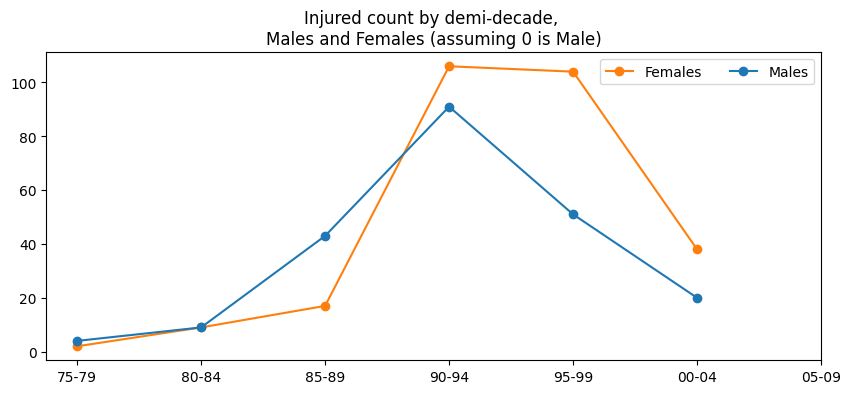

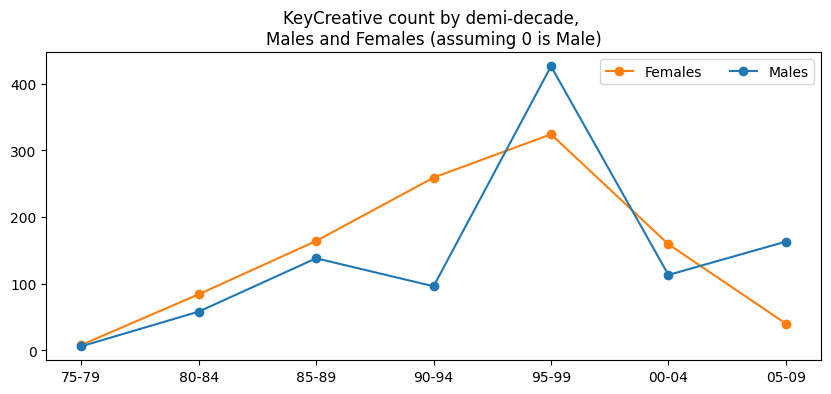

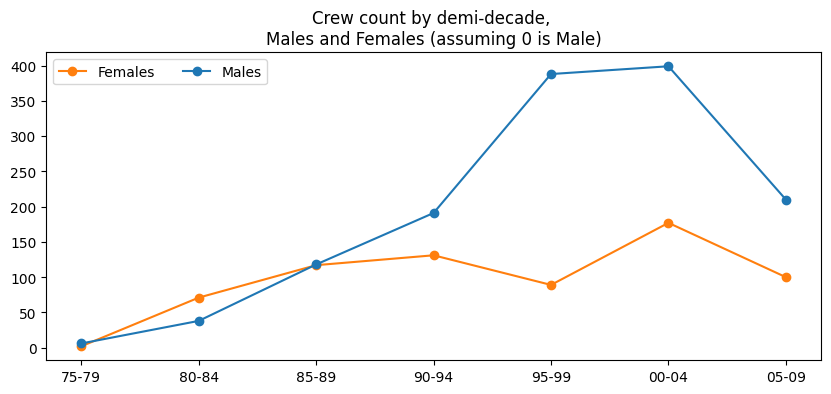

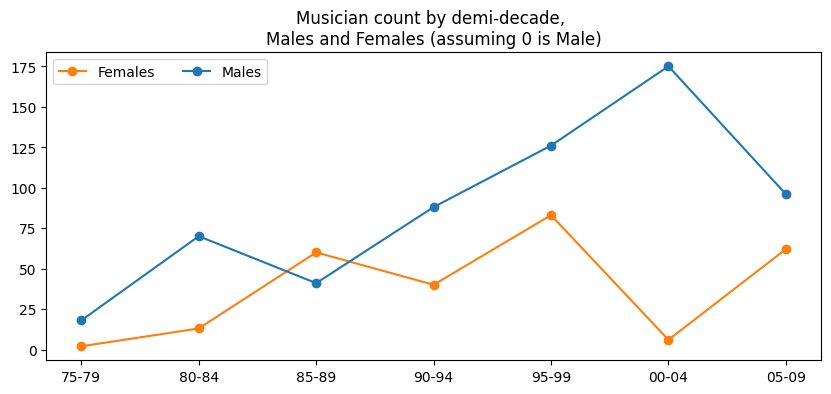

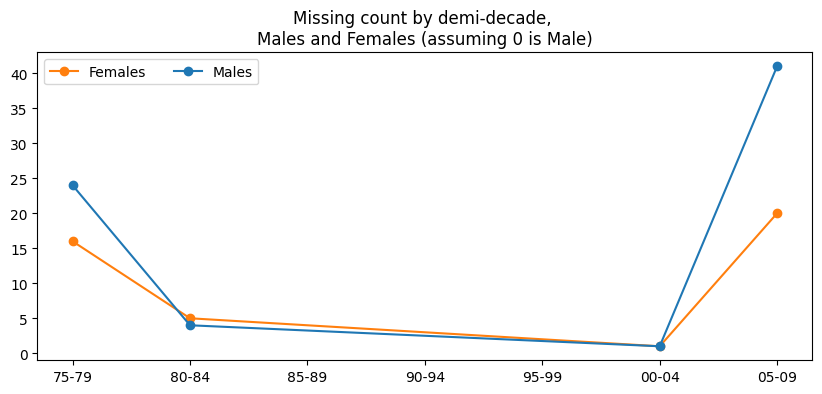

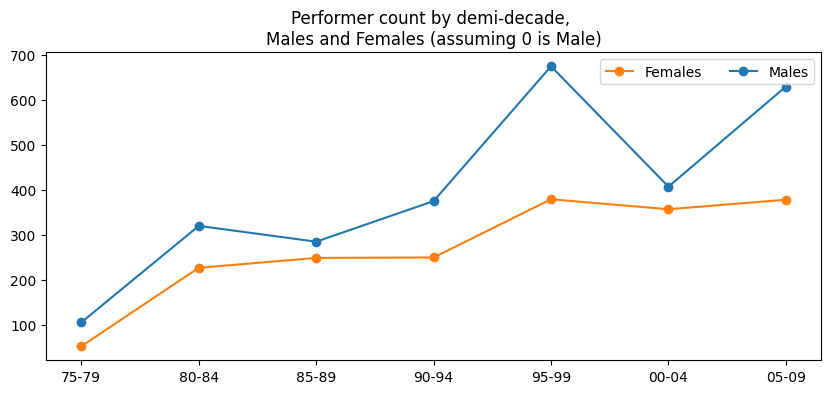

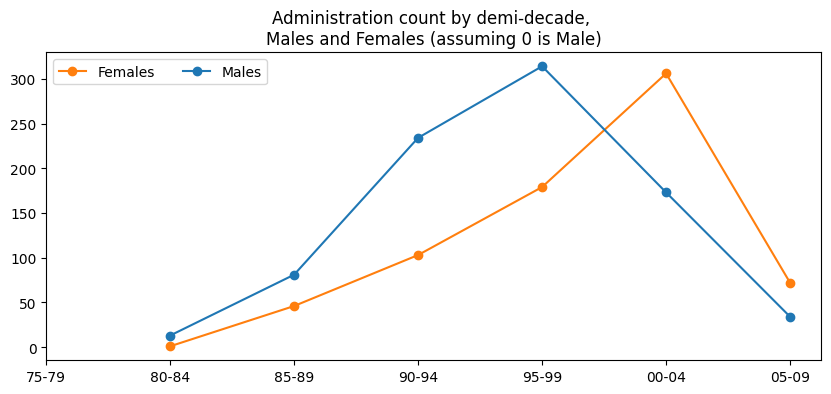

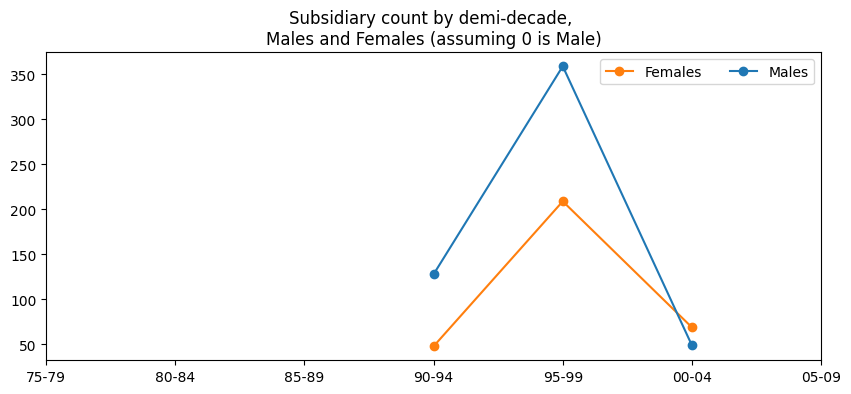

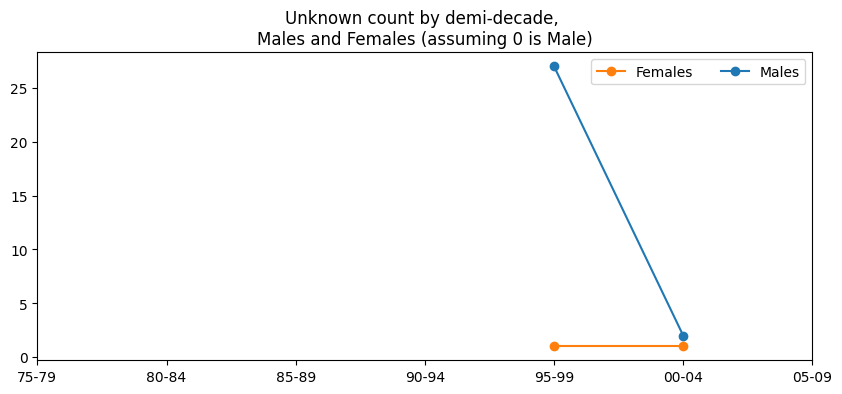

In [60]:
for x in toproles_decade_gender['Role'].unique():
    fig, ax = plt.subplots(figsize=(10, 4))

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Count_f'], 
             label = 'Females', marker='o', color='tab:orange')

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Count_m'], 
             label = 'Males', marker='o',  color='tab:blue')

    plt.legend(loc="best", ncol=3)
    plt.title(f'{x} count by demi-decade, \nMales and Females (assuming 0 is Male)', )
    ax.set_xlabel('')

    plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                                '95-99', '00-04','05-09'])
    plt.show()

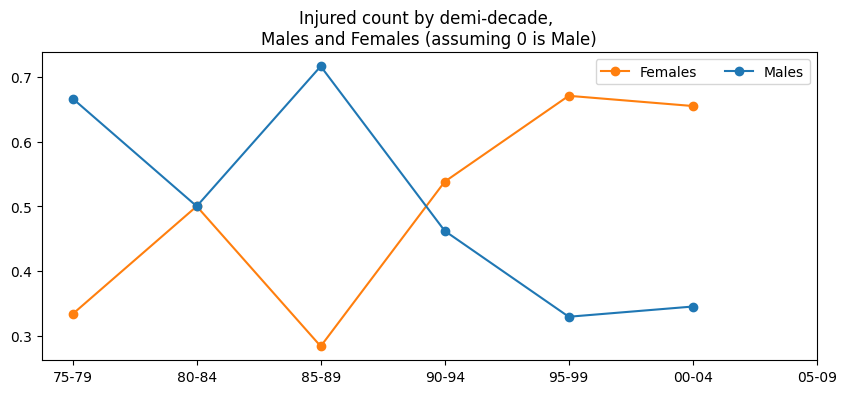

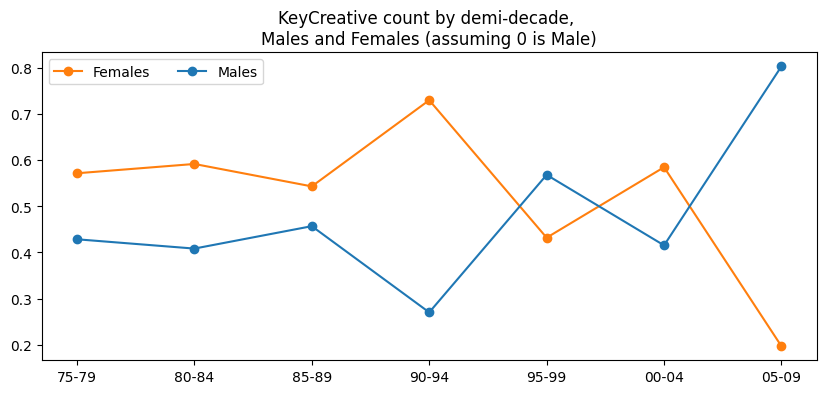

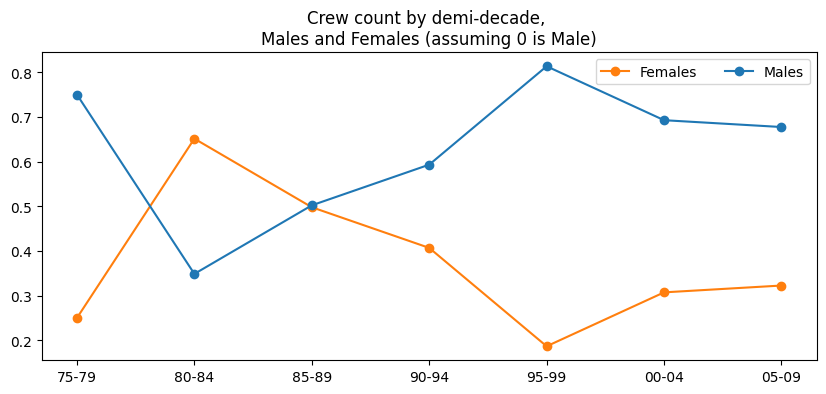

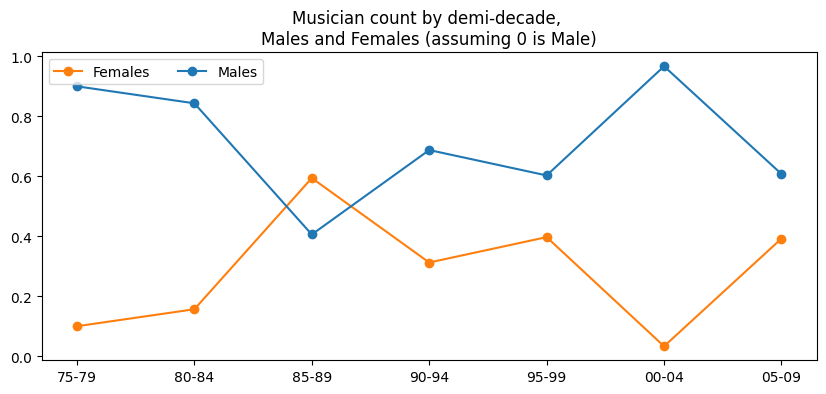

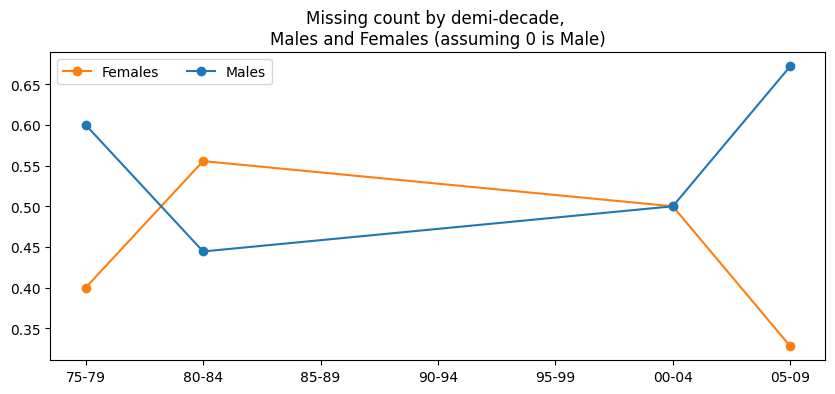

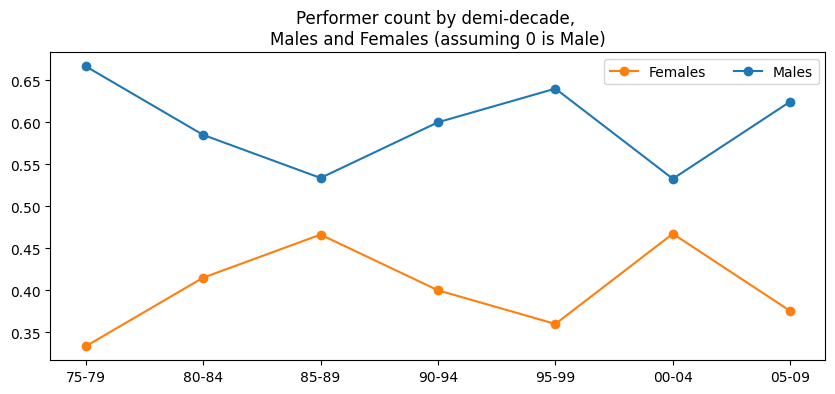

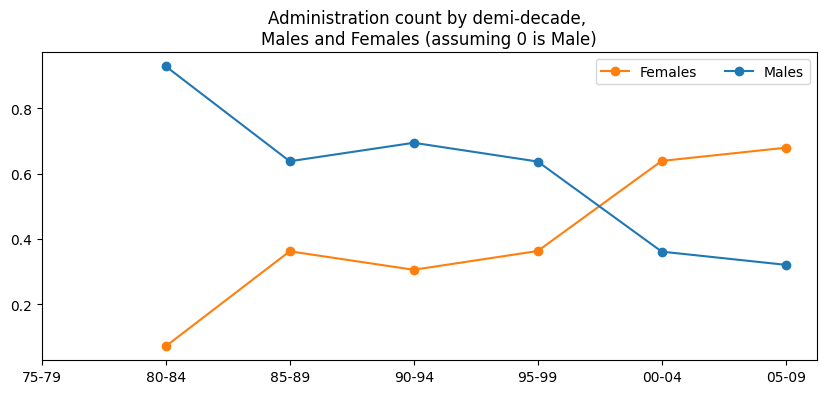

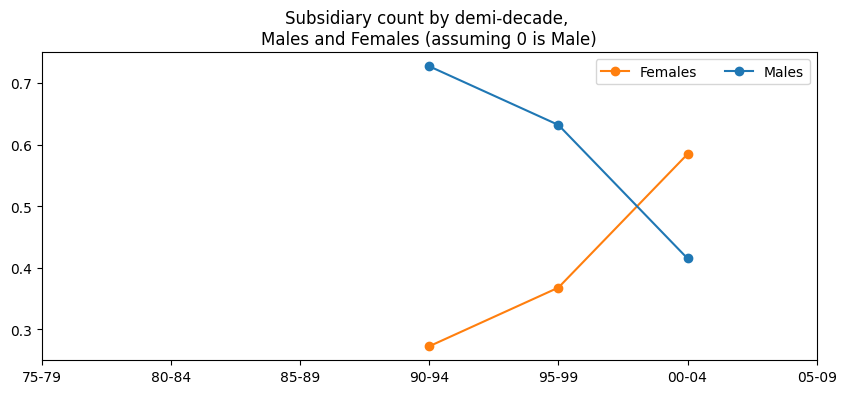

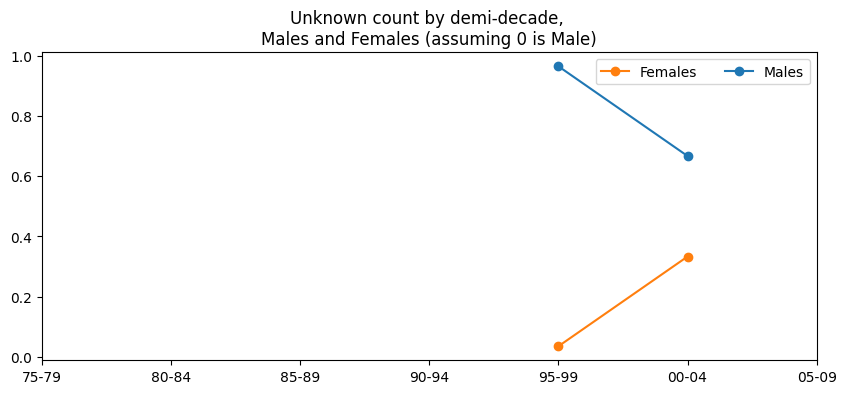

In [61]:
for x in toproles_decade_gender['Role'].unique():
    fig, ax = plt.subplots(figsize=(10, 4))

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Proportion_f'], 
             label = 'Females', marker='o', color='tab:orange')

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Proportion_m'], 
             label = 'Males', marker='o',  color='tab:blue')

    plt.legend(loc="best", ncol=3)
    plt.title(f'{x} count by demi-decade, \nMales and Females (assuming 0 is Male)', )
    ax.set_xlabel('')

    plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                                '95-99', '00-04','05-09'])
    plt.show()

### Role pairings using association rules

- how to interpret values: 
    - diff represents the difference between males and females
    - postiive value signifies that male occurences occur more frequently than female occurrences
    - negative value signifies that female occurences occur more frequently than male occurrences
    
<br>

- Example (1): Males who are musicians (see antecedents) are 33.33% more likely than females to also be a performer (see consequents) in 1975.
- Example (2): Females who are musicians (see antecedents) are 28.5% more likely than males to also be a KeyCreative (see consequents) in 1985.

In [62]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

supports = supports_decade[['antecedents','consequents',
                      'support_x','support_y',
                      'confidence_x','confidence_y','Decade']]
supports['diff'] = (supports['confidence_x'] - supports['confidence_y'])*100
supports_shrt = supports[abs(supports['diff']) > 0.05].sort_values('diff', ascending=False)
supports_shrt[['antecedents','consequents','Decade','diff']]

,antecedents,consequents,Decade,diff
0,(Musician),(Performer),1975,33.333
0,(Injured),(Performer),1995,27.526
3,(KeyCreative),(Performer),1995,23.044
4,(Musician),(Performer),1995,14.926
2,(Performer),(KeyCreative),1995,13.946
1,(Performer),(Musician),1975,12.264
6,(Musician),(Performer),1990,6.591
7,(Performer),(Musician),1990,5.467
4,(Subsidiary),(Performer),2000,5.265
5,(Performer),(Musician),1980,4.360


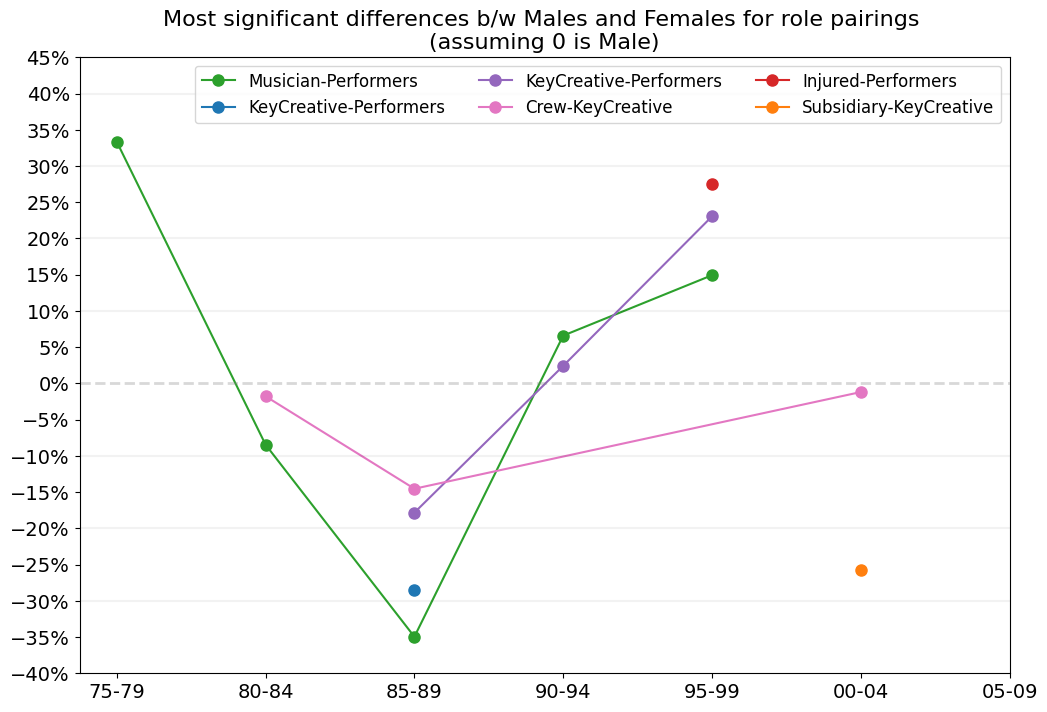

In [63]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 8))

this_pair = supports[(supports.antecedents == frozenset({'Musician'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:green', label='Musician-Performers', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Musician'})) & 
             (supports.consequents == frozenset({'KeyCreative'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:blue', label='KeyCreative-Performers', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'KeyCreative'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:purple', label='KeyCreative-Performers', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Crew'})) & 
             (supports.consequents == frozenset({'KeyCreative'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:pink', label='Crew-KeyCreative', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Injured'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:red', label='Injured-Performers', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Subsidiary'})) & 
             (supports.consequents == frozenset({'KeyCreative'}))]
plt.plot(this_pair['Decade'], this_pair['diff'], marker='o', 
         color='tab:orange', label='Subsidiary-KeyCreative', markersize=8)


plt.title('Most significant differences b/w Males and Females for role pairings \n(assuming 0 is Male)',
         fontsize=16)

plt.axhline(y=0, linestyle='--', color='grey', alpha=0.3, lw=2)
plt.axhline(y=-10, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=-20, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=-30, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=10, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=20, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=30, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=40, linestyle='-', color='black', alpha=0.05)

# adjust legend
ax.legend(loc="upper right", ncol=3, fontsize=12)

plt.yticks(range(-40, 50, 5), range(-40, 50, 5), fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'], fontsize=14)

plt.show()

### Network graphs and association rules

<iframe height="1100" width="800" frameborder="no" src="https://acd-engine.shinyapps.io/CircusOzApp/"> </iframe>